In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [131]:
data = pd.read_csv('all_data.csv')

In [132]:
data.head()

,co2,humi,no,no2,pm10,pm2.5,station,temp,date,time,...,celebration,1,11,14,3,4,7,9,a,b
0,403.0,51.2,NaN,NaN,295.0,118.0,auber,20.4,2013-01-01,10:00:00,...,1.0,0.0,0.0,0.0,389.0,0.0,0.0,402.0,95.0,0.0
1,767.0,46.4,99.0,54.0,362.0,110.0,auber,18.3,2013-01-15,10:00:00,...,0.0,0.0,0.0,0.0,389.0,0.0,0.0,402.0,95.0,0.0
2,495.0,45.0,68.0,45.0,117.0,36.0,auber,18.7,2013-01-12,10:00:00,...,0.0,0.0,0.0,0.0,389.0,0.0,0.0,402.0,95.0,0.0
3,708.0,45.3,90.0,40.0,234.0,73.0,auber,19.5,2013-01-09,10:00:00,...,0.0,0.0,0.0,0.0,389.0,0.0,0.0,402.0,95.0,0.0
4,749.0,41.8,213.0,62.0,314.0,112.0,auber,17.5,2013-01-16,10:00:00,...,0.0,0.0,0.0,0.0,389.0,0.0,0.0,402.0,95.0,0.0


In [133]:
for col in data.columns:
    print("missing data in {} : {} i.e. {}%".format(col,len(data[data[col].isnull()]),
                                                       len(data[data[col].isnull()])/float(len(data))*100))

missing data in co2 : 6397 i.e. 9.128399783098832%
missing data in humi : 3107 i.e. 4.4336310967778765%
missing data in no : 17234 i.e. 24.59259682068552%
missing data in no2 : 8799 i.e. 12.556009018522218%
missing data in pm10 : 6162 i.e. 8.793059162647337%
missing data in pm2.5 : 38523 i.e. 54.97160307086389%
missing data in station : 0 i.e. 0.0%
missing data in temp : 3131 i.e. 4.467878649504837%
missing data in date : 0 i.e. 0.0%
missing data in time : 0 i.e. 0.0%
missing data in precipitation : 96 i.e. 0.13699021090784552%
missing data in temp_min : 96 i.e. 0.13699021090784552%
missing data in temp_max : 96 i.e. 0.13699021090784552%
missing data in holiday : 0 i.e. 0.0%
missing data in celebration : 0 i.e. 0.0%
missing data in 1 : 0 i.e. 0.0%
missing data in 11 : 0 i.e. 0.0%
missing data in 14 : 0 i.e. 0.0%
missing data in 3 : 0 i.e. 0.0%
missing data in 4 : 0 i.e. 0.0%
missing data in 7 : 0 i.e. 0.0%
missing data in 9 : 0 i.e. 0.0%
missing data in a : 0 i.e. 0.0%
missing data in 

Top three missing data columns :  
-no  
-pm10  
-pm2.5  
-co2  

WARNING no missing data in timetable, stations ect... because I(romain) generated the data

#### Date & Time processing

In [134]:
data['datetime'] = data['date'].str.cat(data['time'].astype(str), sep = ' ')

In [135]:
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')

In [136]:
data['year'],data['month'],data['day'] = data["date"].str.split("-").str
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data['day'] = data['day'].astype(int)

In [137]:
data['hour'],data['minute'],data['second'] = data["time"].str.split(":").str
data['hour'] = data['hour'].astype(int)
data['minute'] = data['minute'].astype(int)
data['second'] = data['second'].astype(int)

In [138]:
data = data.drop(labels = ['minute','second'], axis = 1)

In [139]:
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")

In [140]:
data['week'] = data['date'].dt.week

In [141]:
data['weekday'] = data['date'].dt.dayofweek

In [142]:
data['time'] = pd.to_datetime(data['time'], format = "%H:%M:%S")

In [143]:
data['time'] = data["time"].dt.time

In [144]:
print(len(data[data["co2"].isnull() & 
                        data["humi"].isnull() &
                        data["no"].isnull() & 
                        data["no2"].isnull() &
                        data["pm10"].isnull() & 
                        data["pm2.5"].isnull() &  
                       data["temp"].isnull()]))

3070


For 15860 raws, data is missing for almost all sensors (except rain) -> remove all these rows

In [145]:
missing_data = data[data["co2"].isnull() | 
                        data["humi"].isnull() |
                        data["no"].isnull() | 
                        data["no2"].isnull() |
                        data["pm10"].isnull() | 
                        data["pm2.5"].isnull() | 
                        data["no2"].isnull() |
                       data["temp"].isnull()]

In [146]:
missing_data.head()

,co2,humi,no,no2,pm10,pm2.5,station,temp,date,time,...,9,a,b,datetime,year,month,day,hour,week,weekday
0,403.0,51.2,NaN,NaN,295.0,118.0,auber,20.4,2013-01-01,10:00:00,...,402.0,95.0,0.0,2013-01-01 10:00:00,2013,1,1,10,1,1
5,NaN,44.2,235.0,48.0,654.0,254.0,auber,17.8,2013-01-17,10:00:00,...,402.0,95.0,0.0,2013-01-17 10:00:00,2013,1,17,10,3,3
8,590.0,52.2,NaN,NaN,911.0,374.0,auber,21.6,2013-01-04,10:00:00,...,402.0,95.0,0.0,2013-01-04 10:00:00,2013,1,4,10,1,4
16,616.0,48.2,NaN,NaN,857.0,306.0,auber,20.4,2013-01-02,10:00:00,...,402.0,95.0,0.0,2013-01-02 10:00:00,2013,1,2,10,1,2
19,663.0,52.6,NaN,NaN,633.0,247.0,auber,21.0,2013-01-03,10:00:00,...,402.0,95.0,0.0,2013-01-03 10:00:00,2013,1,3,10,1,3


/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


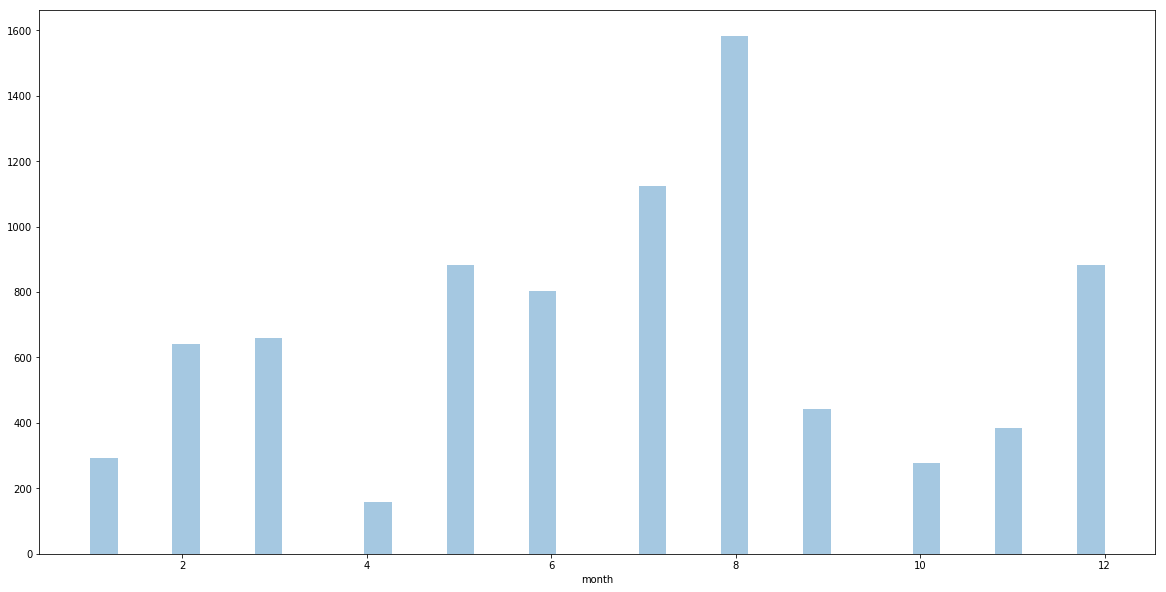

In [147]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(missing_data[missing_data['station'] == 'auber']['month'], ax = ax, kde = False)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


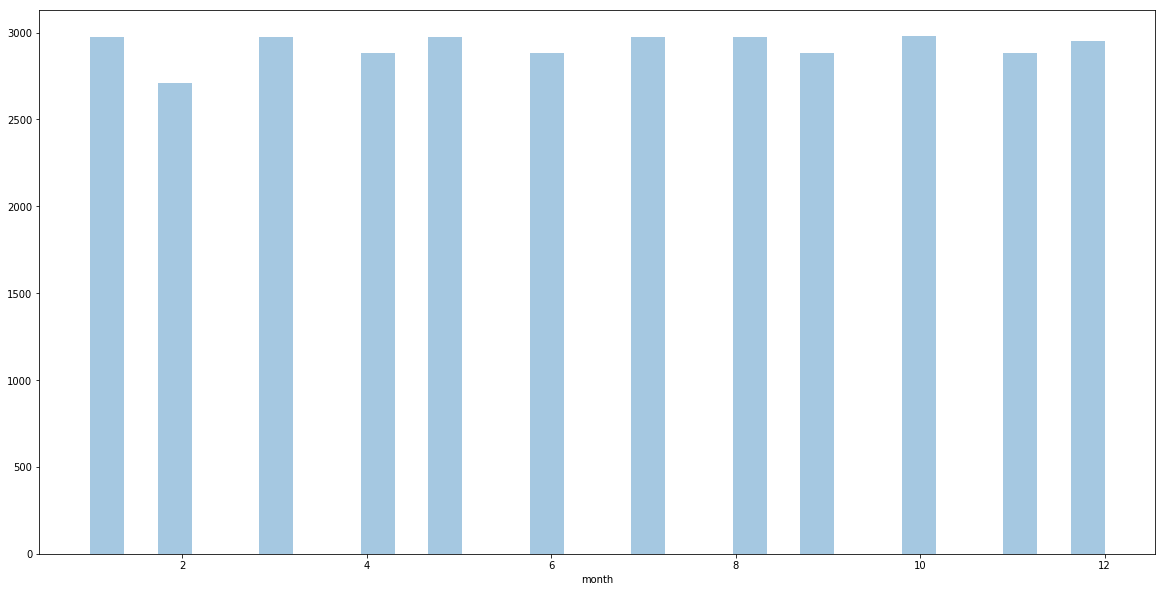

In [148]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(missing_data[missing_data['station'] == 'chatelet']['month'], ax = ax, kde = False)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


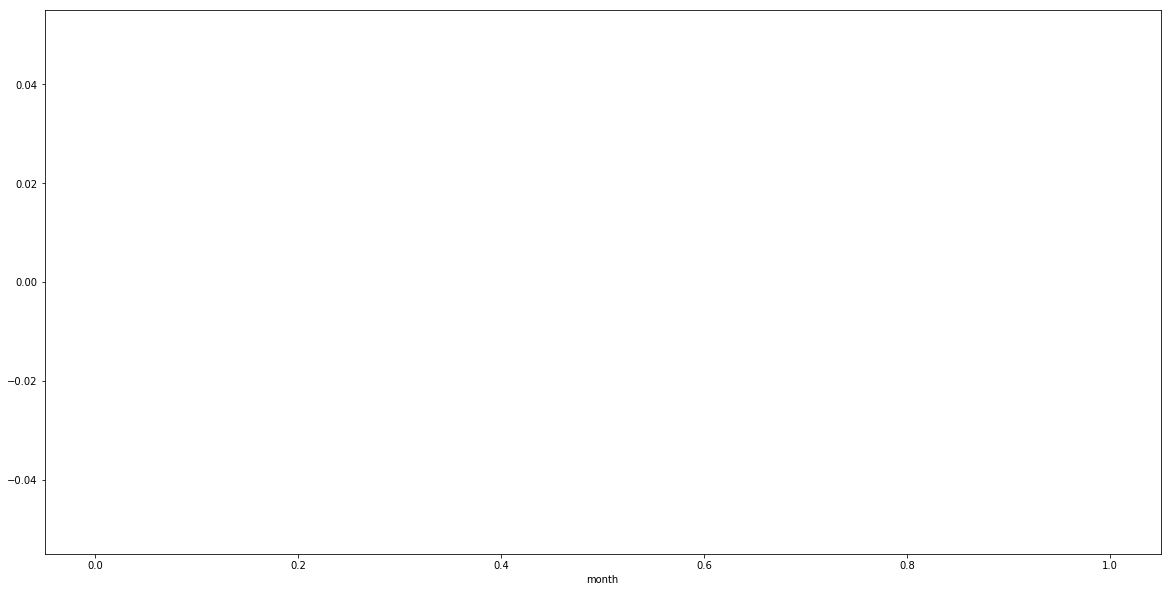

In [149]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(missing_data[missing_data['station'] == 'franklin']['month'], ax = ax, kde = False)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


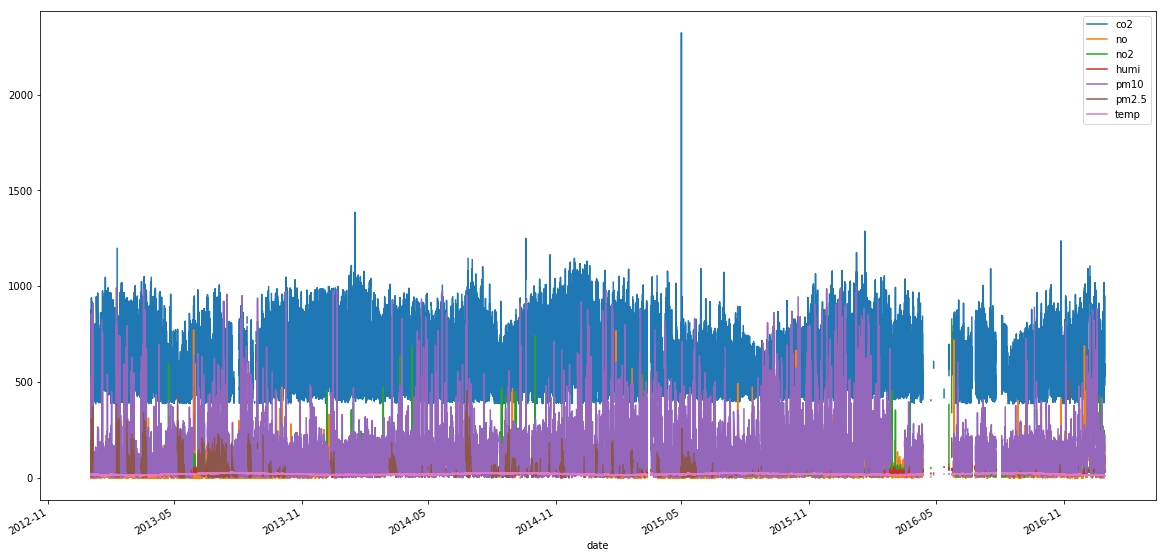

In [150]:
fig, ax = plt.subplots(figsize=(20,10))
missing_data.plot(x = 'date', y = ['co2','no','no2','humi','pm10','pm2.5','temp'], ax = ax)
plt.show()

A chatelet il semble que le mois d'aout contiennent le plus de valeurs manquantes (# vacances), les autres contiennent une quantité constante de données manquantes.

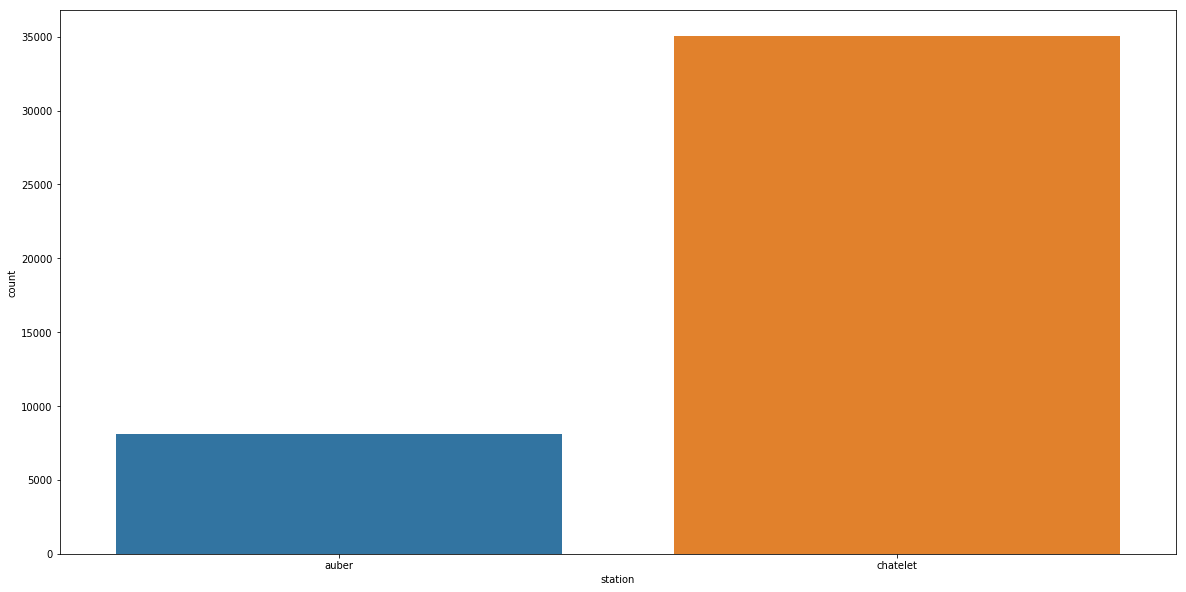

In [151]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(ax=ax,data = missing_data,x="station")

Let's choose auber because, it is the station with the least missing data


In [152]:
data = data.drop(labels=['no','no2','pm10','pm2.5'], axis = 1)

In [153]:
data = data.dropna()

In [154]:
data = data[data['station'] == 'auber']

###### Frequentation
Frequentation is the sum of the trains per hour over all lines

In [155]:
data['frequentation'] = data['a']+data['b']+data['1']+data['11']+data['14']+data['3']+data['4']+data['7']+data['9']

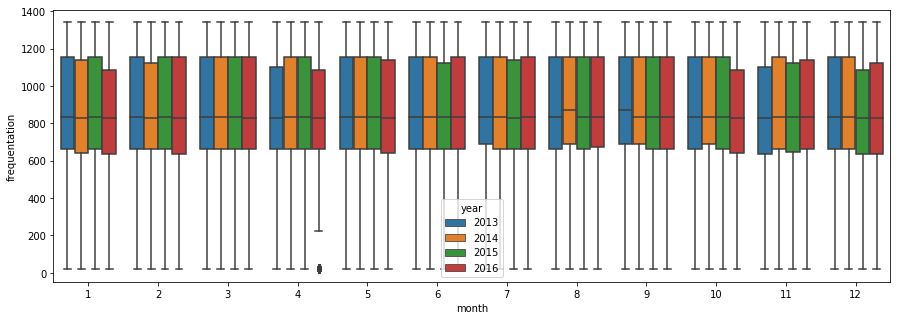

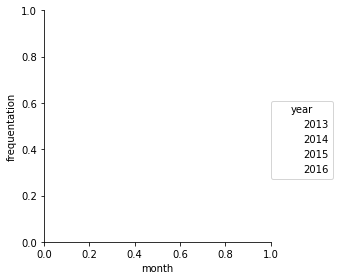

In [156]:
fig, ax = plt.subplots(figsize=(15,5))
sns.factorplot(x="month", y="frequentation", hue = "year", data=data, kind = "box", ax = ax)

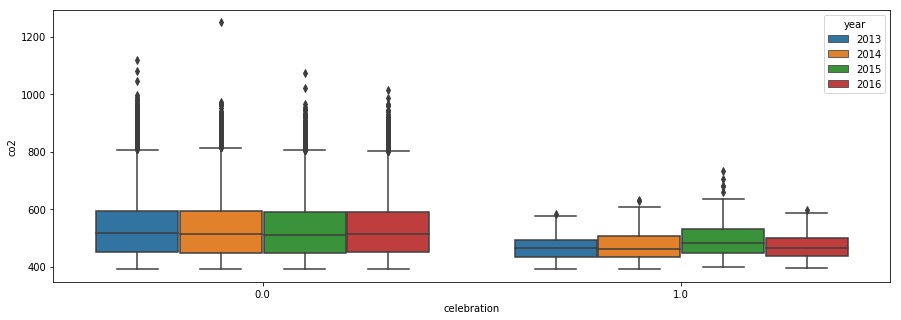

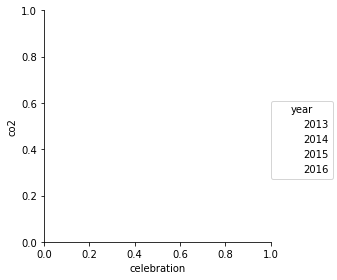

In [157]:
fig, ax = plt.subplots(figsize=(15,5))
sns.factorplot(x="celebration", y="co2", hue = "year", data=data, kind = "box", ax = ax)

In [158]:
mask = (data['date'] > pd.datetime(2016,1,1)) & (data['date'] <= pd.datetime(2016,1,2))

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


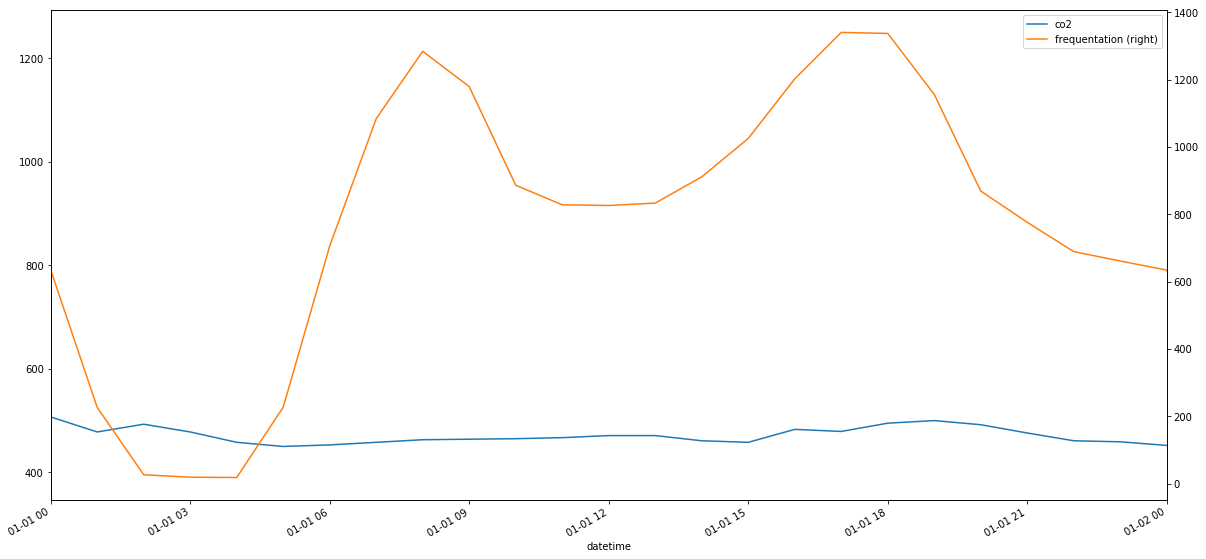

In [159]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlim([pd.datetime(2016,1,1,0),pd.datetime(2016,1,2,0)])
data.plot(x = ['datetime'],y = ['co2'], ax = ax)
data.plot(x = ['datetime'],y = ['frequentation'], ax = ax, secondary_y = True)


###### Time delay
Adding a time to take in account the forecasting aspect

In [160]:
delay = 24
data['co2_delay'] = data['co2']
data['co2_delay'] = data['co2_delay'].shift(delay)

In [161]:
data_2013 = data[(data['year'] == 2013) & (data['month'] == 1)]

In [162]:
data_2013['co2_d'] = pd.rolling_mean(data_2013['co2'], window = 24, min_periods=1)
data_2013['co2_w'] = pd.rolling_mean(data_2013['co2'], window = 24*7, min_periods=1)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=1,center=False).mean()
  """Entry point for launching an IPython kernel.
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=168,min_periods=1,center=False).mean()
  
/home/romain/.

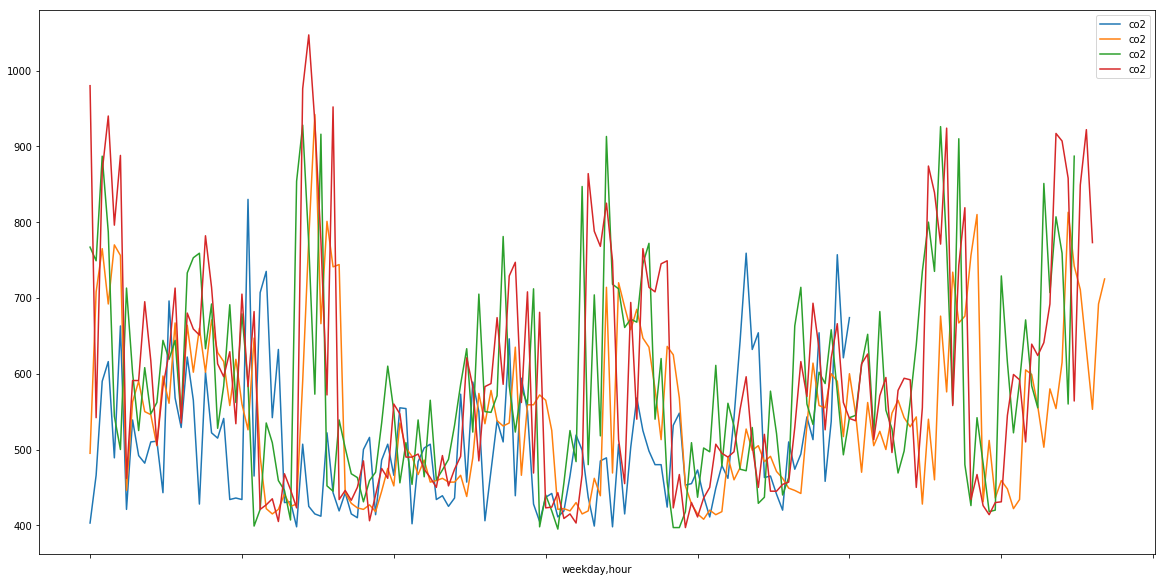

In [163]:
fig, ax = plt.subplots(figsize=(20,10))
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = 'co2', ax = ax)
data_2013[data_2013["week"] == 2].plot(x = ['weekday','hour'],y = 'co2', ax = ax)
data_2013[data_2013["week"] == 3].plot(x = ['weekday','hour'],y = 'co2', ax = ax)
data_2013[data_2013["week"] == 4].plot(x = ['weekday','hour'],y = 'co2', ax = ax)

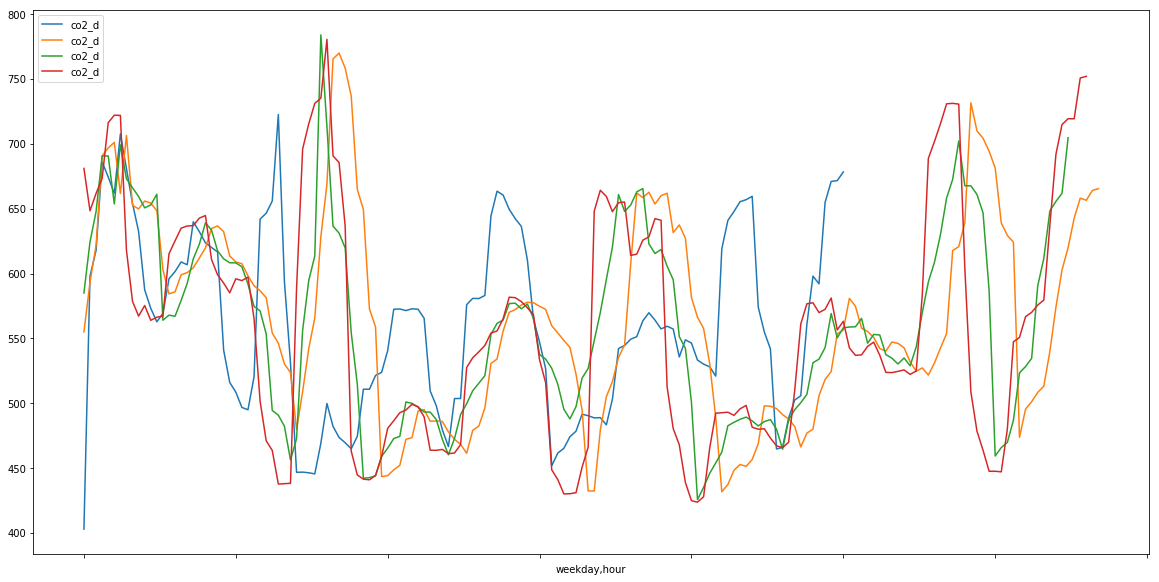

In [164]:
fig, ax = plt.subplots(figsize=(20,10))
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = 'co2_d', ax = ax)
data_2013[data_2013["week"] == 2].plot(x = ['weekday','hour'],y = 'co2_d', ax = ax)
data_2013[data_2013["week"] == 3].plot(x = ['weekday','hour'],y = 'co2_d', ax = ax)
data_2013[data_2013["week"] == 4].plot(x = ['weekday','hour'],y = 'co2_d', ax = ax)

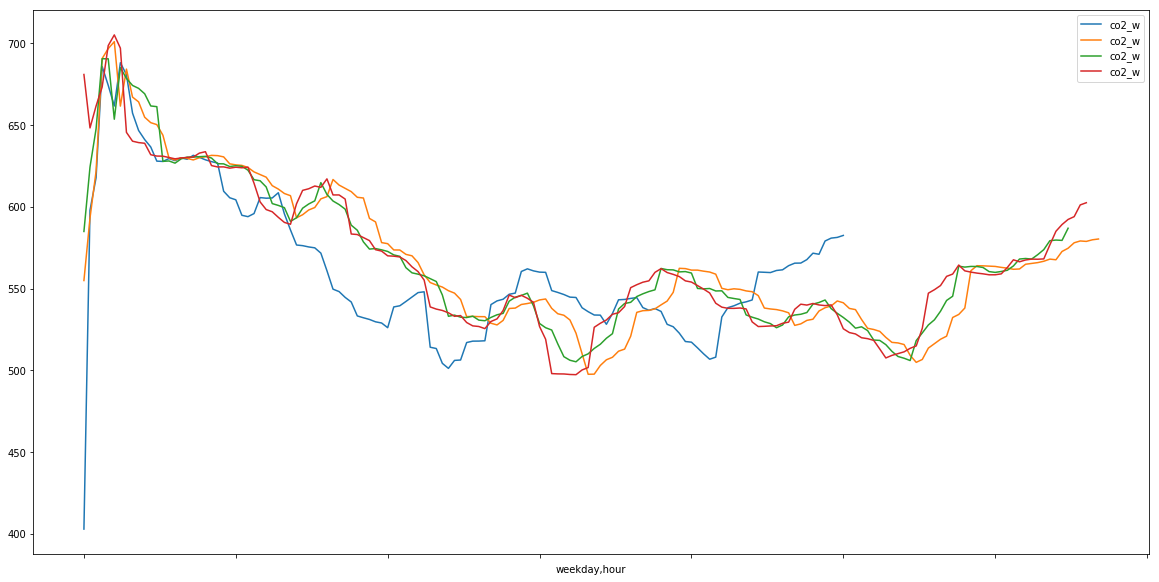

In [166]:
fig, ax = plt.subplots(figsize=(20,10))
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = 'co2_w', ax = ax)
data_2013[data_2013["week"] == 2].plot(x = ['weekday','hour'],y = 'co2_w', ax = ax)
data_2013[data_2013["week"] == 3].plot(x = ['weekday','hour'],y = 'co2_w', ax = ax)
data_2013[data_2013["week"] == 4].plot(x = ['weekday','hour'],y = 'co2_w', ax = ax)

In [167]:
data['co2_d'] = pd.rolling_mean(data['co2'], window = 24, min_periods=1)
data['co2_w'] = pd.rolling_mean(data['co2'], window = 24*7, min_periods=1)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=1,center=False).mean()
  """Entry point for launching an IPython kernel.
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=168,min_periods=1,center=False).mean()
  


In [168]:
data = data[['frequentation','year','month','day','hour','weekday','week','precipitation','temp_min','temp_max','co2','co2_d','co2_w','celebration','holiday']]

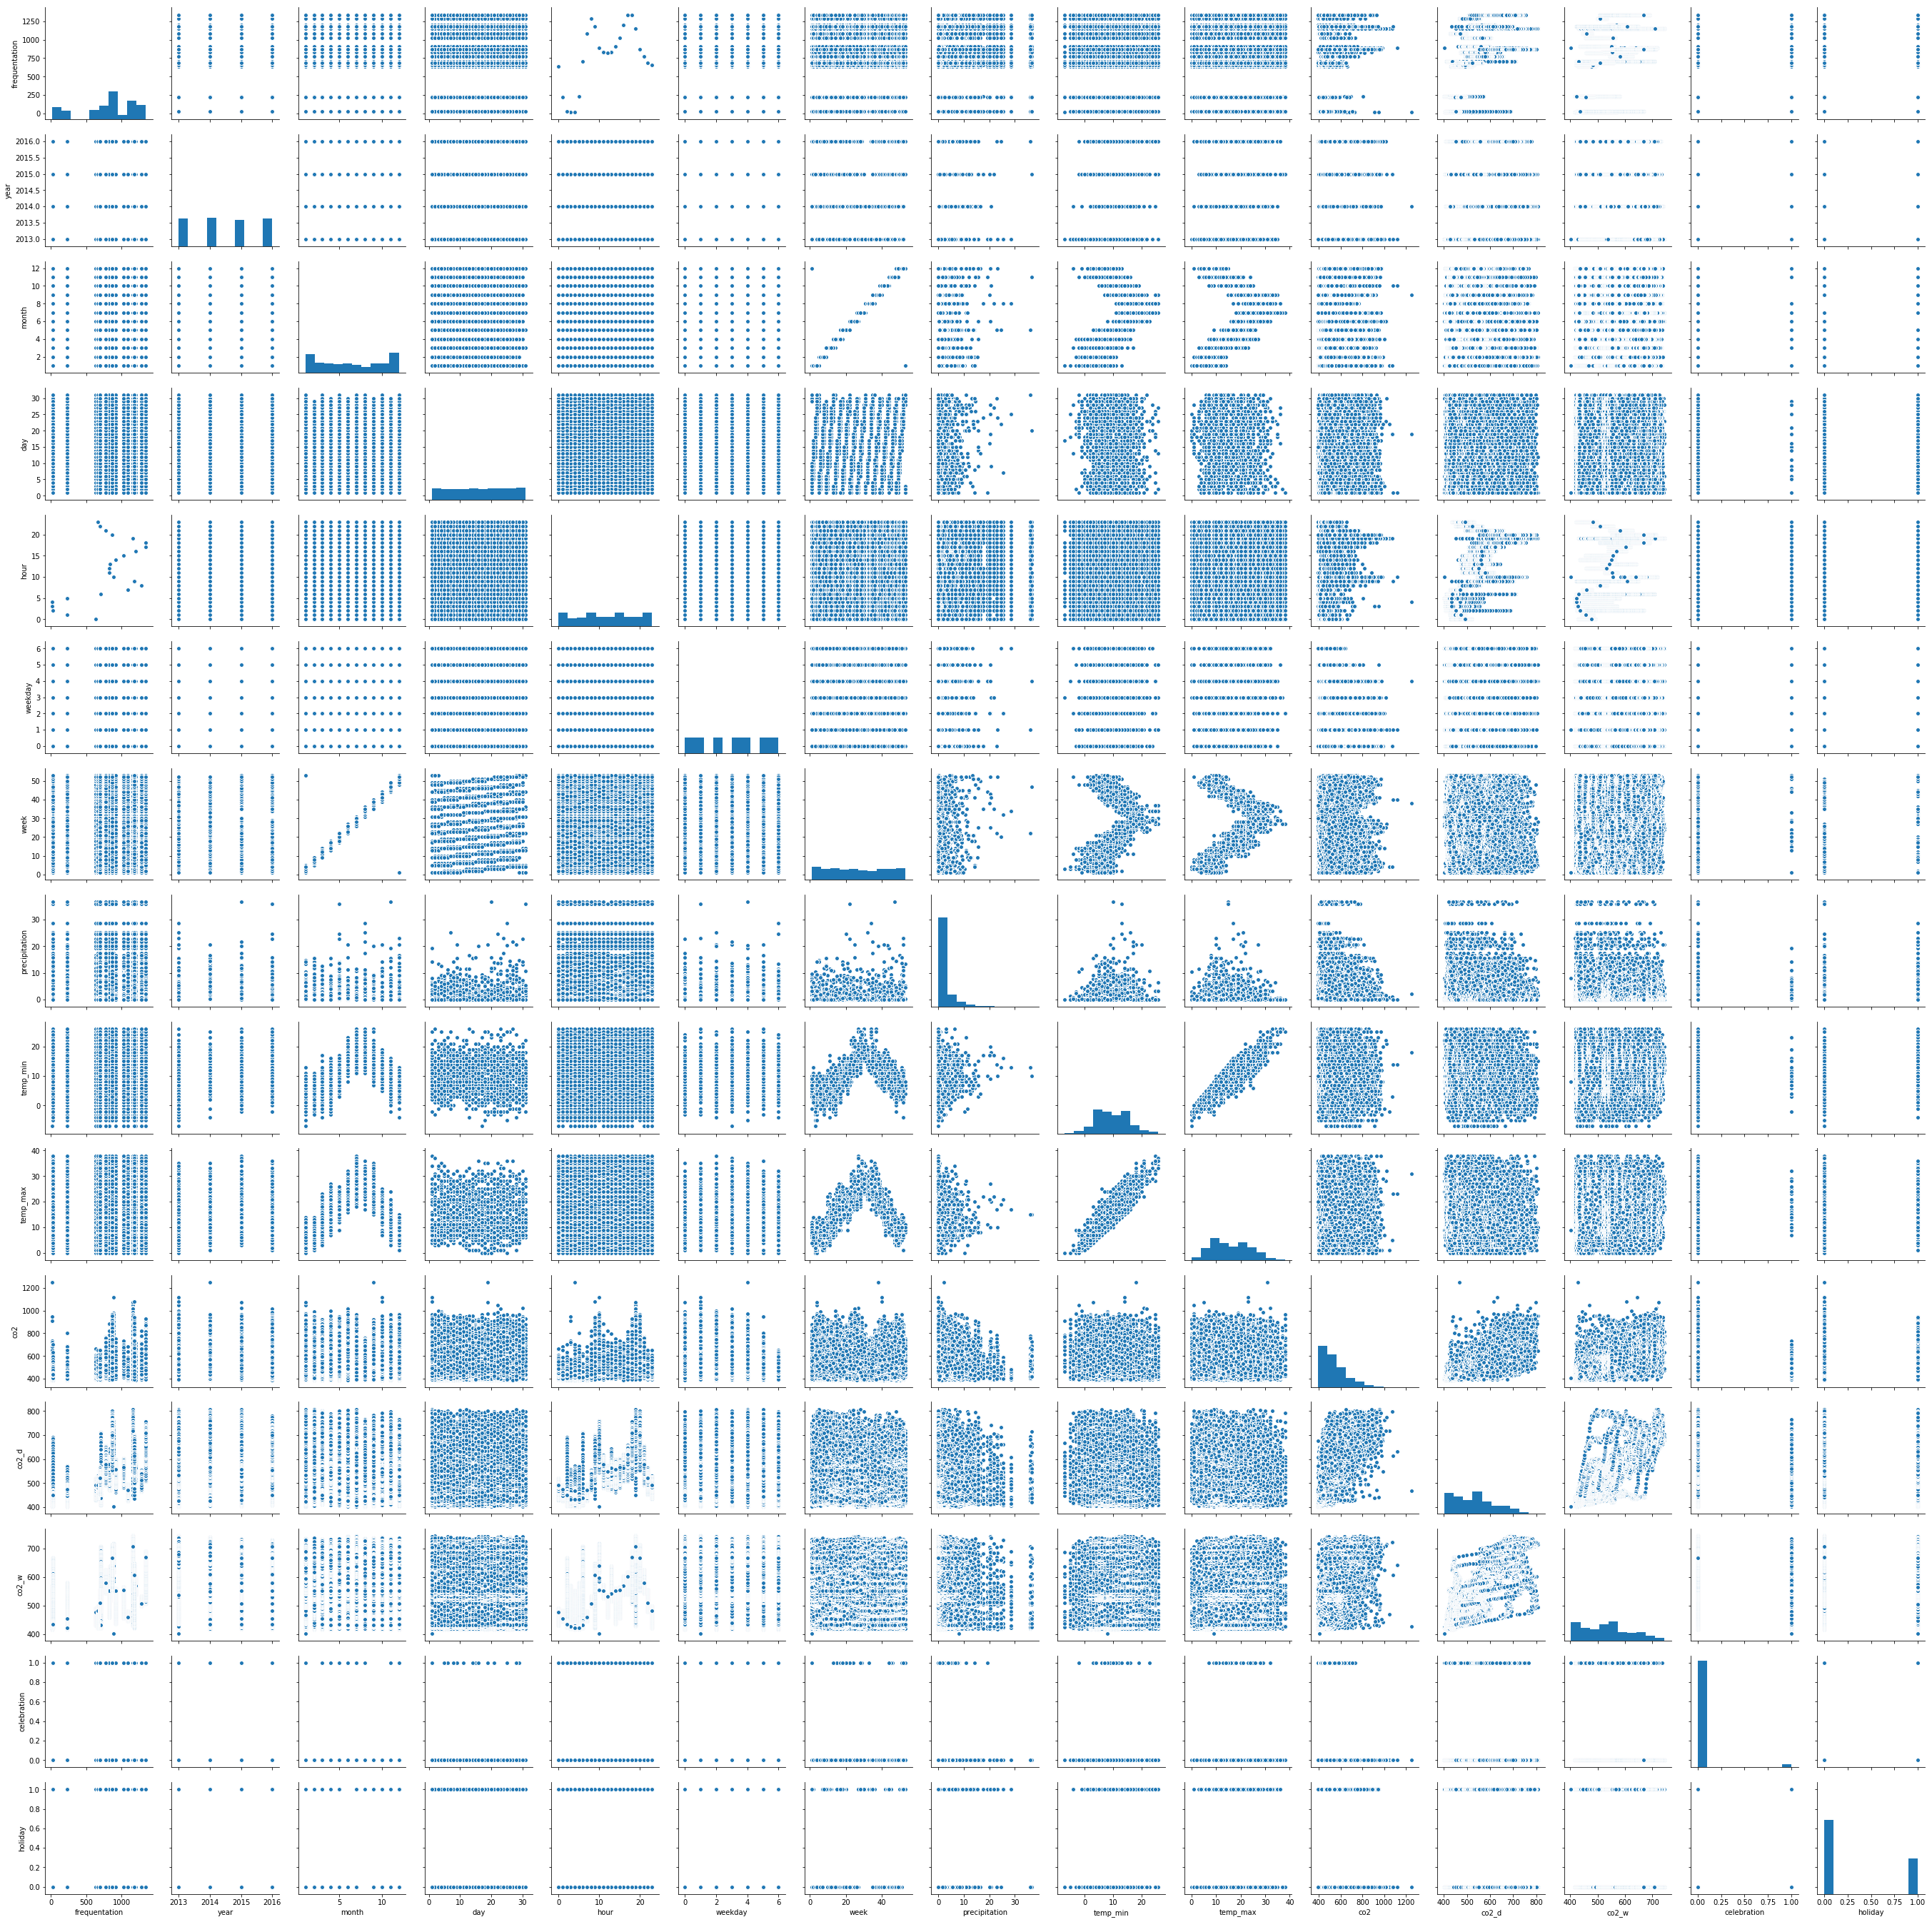

In [169]:
sns.pairplot(data)

In [170]:
corr = data.corr()

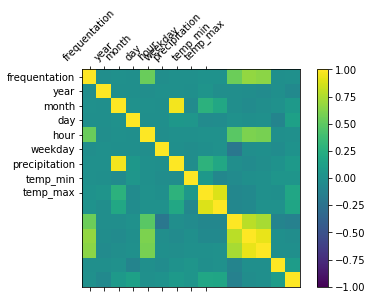

In [171]:
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

names = ['frequentation', 'year', 'month','day', 'hour', 'weekday', 'precipitation', 'temp_min','temp_max','co2_d','co2_w','co2','celebration','holiday']
ax.set_xticklabels(names, rotation = 45)
ax.set_yticklabels(names)
plt.show()

## Feature engineering

In [172]:
data['co2_log'] = data['co2'].apply(lambda x:np.log(x))
data['co2_d_log'] = data['co2_d'].apply(lambda x:np.log(x))
data['co2_w_log'] = data['co2_w'].apply(lambda x:np.log(x))
data['precipitation_log'] = data['precipitation'].apply(lambda x:np.log(x+0.001))

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

#### Normalization

In [184]:
from sklearn.preprocessing import StandardScaler
co2_scale = StandardScaler()
co2_scale.fit_transform(data['co2_log'].reshape(-1, 1))

co2_d_scale = StandardScaler()
co2_d_scale.fit_transform(data['co2_d_log'].reshape(-1, 1))

co2_w_scale = StandardScaler()
co2_w_scale.fit_transform(data['co2_w_log'].reshape(-1, 1))

precipitation_scale = StandardScaler()
precipitation_scale.fit_transform(data['precipitation_log'].reshape(-1, 1))

hour_scale = StandardScaler()
hour_scale.fit_transform(data['hour'].reshape(-1, 1))

week_day_scale = StandardScaler()
week_day_scale.fit_transform(data['weekday'].reshape(-1, 1))

day_scale = StandardScaler()
day_scale.fit_transform(data['day'].reshape(-1, 1))

month_scale = StandardScaler()
month_scale.fit_transform(data['month'].reshape(-1, 1))

year_scale = StandardScaler()
year_scale.fit_transform(data['year'].reshape(-1, 1))

temp_min_scale = StandardScaler()
temp_min_scale.fit_transform(data['temp_min'].reshape(-1, 1))

temp_max_scale = StandardScaler()
temp_max_scale.fit_transform(data['temp_max'].reshape(-1, 1))


/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/home/romain/.virtualenvs/python3.6/l

array([[-0.91075468],
       [-1.96822514],
       [-1.57167372],
       ...,
       [-0.51420326],
       [-0.24983565],
       [-1.1751223 ]])

## Modelization

In [187]:
features = ['frequentation','year','month','day','hour', 'weekday', 'precipitation','temp_min','temp_max','co2_d', 'co2_w','celebration','holiday']
X = data[features].values
Y = data['co2'].values.reshape(-1,1)

In [188]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble

In [189]:
cv_ratio = 0.8

In [190]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

#### Ridge Regression

In [191]:
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.6923403458003135

In [192]:
for idx in range(len(features)):
    print(features[idx],clf.coef_[idx])

frequentation 0.005523483266180625
year -0.5180216047802189
month 0.8499494828724369
day 0.19258112341779862
hour 0.17109278165377403
weekday -10.833985689255691
precipitation -1.002604842916558
temp_min -0.07480982839233931
temp_max -0.3123295711384608
co2_d 0.970883337831042
co2_w -0.014794696174913118
celebration -50.38758860730234
holiday -19.74743093292325


#### ElasticNet Regression

In [193]:
clf = linear_model.ElasticNet(alpha = 0.1)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.6891155235297479

In [194]:
for idx in range(len(features)):
    print(features[idx],clf.coef_[idx])

frequentation 0.005508871809003272
year -0.48560843708908
month 0.7961748955479756
day 0.23504200548722673
hour 0.168346911244683
weekday -10.651976018165353
precipitation -1.0948400072815994
temp_min -0.0
temp_max -0.39015522533695973
co2_d 0.975067108482251
co2_w -0.018567475820634102
celebration -19.33008430664868
holiday -17.266630372305322


#### Random Forest Regression

In [198]:
clf = ensemble.RandomForestRegressor(n_estimators = 1000)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8942747946723785

In [197]:
for idx in range(len(features)):
    print(features[idx],clf.feature_importances_[idx])

frequentation 0.012005513654079902
year 0.006772580639246035
month 0.016886440237709875
day 0.018091871355624182
hour 0.028451916958591065
weekday 0.15605872796117065
precipitation 0.01342650364629262
temp_min 0.014287101577196759
temp_max 0.018062916305935407
co2_d 0.6544461669466396
co2_w 0.02597100526823647
celebration 0.023139114490397326
holiday 0.012400140958880068
